In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,MultiHeadAttention, InputLayer, LSTM, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Bidirectional, TimeDistributed, Dropout, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW, Adam

from shared import read_dataset, plot_results, evaluate_price_predictions, mean_abs_error

#Trading Days: (2731, 24)


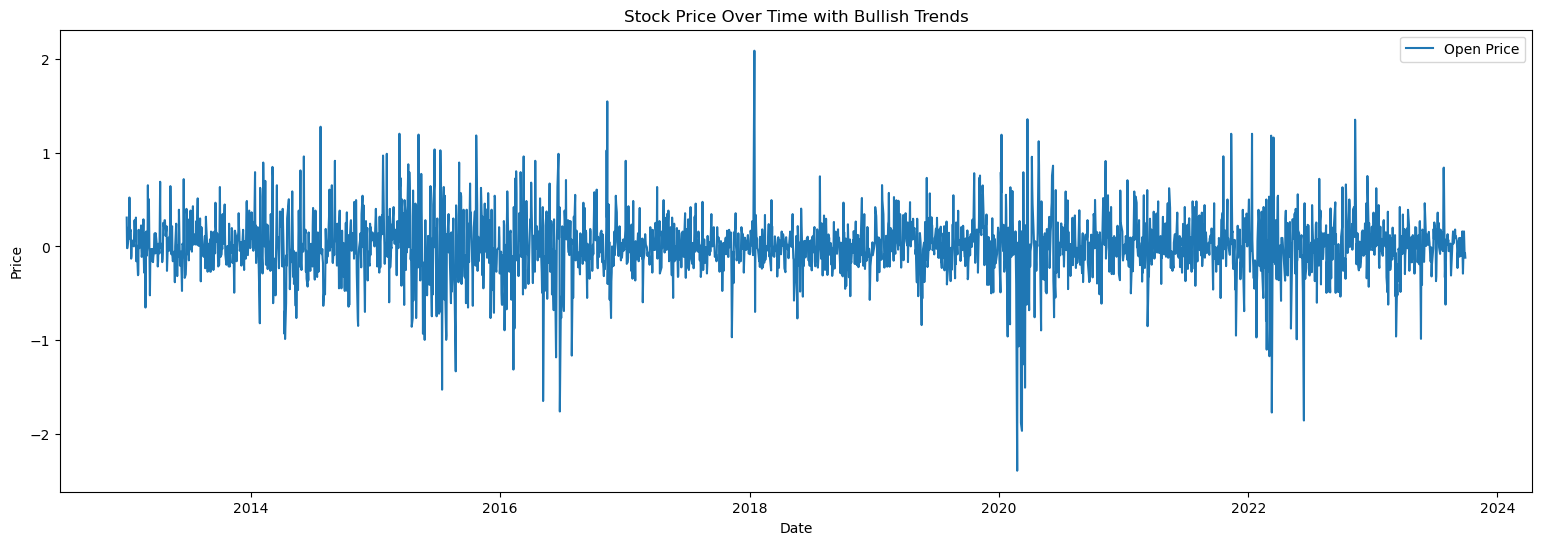

['High Diff', 'Open', 'High', 'Low', 'Close', 'Volume', 'ma7', 'ma7_diff', 'ma21', 'ma21_diff', '26ema', '26ema_diff', '12ema', '12ema_diff', 'MACD', 'upper_band', 'lower_band', 'momentum', 'fourier_short', 'fourier_medium', 'fourier_long', 'Volatility_21', 'Close Diff', 'Open Diff']


In [13]:
start = "2013-01-01"
end = "2023-10-01"
target_column_name = 'High Diff'
path = '../models/lstm_model/predictor_adj_close.h5'

AZM = read_dataset('../data/AZM.MI_ta.csv', start, end)

data = AZM
data.dropna(inplace=True)

cols = [target_column_name] + [ col for col in data if col != target_column_name]
target_column = list(data.columns).index(target_column_name)
data = data[cols]

print(f"#Trading Days: {data.shape}")

plt.figure(figsize=(19, 6))
plt.plot(data[target_column_name], label='Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time with Bullish Trends')
plt.legend()
plt.show()
print(cols)

In [14]:
data.shape

(2731, 24)

#Trading Days: (2495, 21)

In [26]:
SEQUENCE_LENGTH = 20
PREDICTION_SHIFT= 0
NUM_FEATURES = 24

# data = data.drop('Low Diff', axis=1)
# data = data.drop('Adj Close', axis=1)

# Define feature array and target array to train the model.
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

def create_sequences(data, target, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)-PREDICTION_SHIFT):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(target[i+PREDICTION_SHIFT])
    return np.array(sequence_data), np.array(sequence_target)

data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH)

# Split the data
train_size = int(data_sequences.shape[0]* 0.9)
evaluation_size = int(0) # no evaluation


train_data, validation_data, test_data = data_sequences[:train_size], data_sequences[train_size:train_size+evaluation_size], data_sequences[train_size+evaluation_size:]
train_target, validation_target, test_target = target_sequences[:train_size], target_sequences[train_size:train_size+evaluation_size], target_sequences[train_size+evaluation_size:]

train_data = train_data.reshape(train_data.shape[0], 1, SEQUENCE_LENGTH, NUM_FEATURES)
validation_data = validation_data.reshape(validation_data.shape[0], 1,SEQUENCE_LENGTH, NUM_FEATURES)
test_data = test_data.reshape(test_data.shape[0], 1, SEQUENCE_LENGTH, NUM_FEATURES)

print(f"Train | data: {train_data.shape} target: {train_target.shape}")
print(f"Valid | data: {validation_data.shape} target: {validation_target.shape}")
print(f"Testt | data: {test_data.shape} target: {test_target.shape}")


Train | data: (2439, 1, 20, 24) target: (2439, 1)
Valid | data: (0, 1, 20, 24) target: (0, 1)
Testt | data: (272, 1, 20, 24) target: (272, 1)


In [27]:
# TESTING CORRECTNESS OF GENERATED SEQUENCES
test_index = -2
test_column_prompt = 0
a = scaler_data.inverse_transform(data_sequences[test_index])
b = scaler_target.inverse_transform(target_sequences)

for i in range (0, SEQUENCE_LENGTH):
    print(f"A[{i}]: {a[i][test_column_prompt]}")

print(f'b: {b[test_index]}')

A[0]: 0.0900001525878941
A[1]: 0.11000061035156251
A[2]: 0.05999946594238301
A[3]: -0.030000686645507608
A[4]: -0.2299995422363315
A[5]: -0.07999992370605094
A[6]: -0.030000686645511084
A[7]: 0.0900001525878941
A[8]: -0.10999870300292981
A[9]: -0.050001144409172554
A[10]: 0.09000015258788366
A[11]: 0.05999946594238301
A[12]: -0.09999847412109361
A[13]: 0.01999855041503572
A[14]: 0.1599998474121128
A[15]: -0.11999893188476204
A[16]: -0.2900009155273507
A[17]: 0.1599998474121128
A[18]: 0.030000686645507608
A[19]: -0.11000061035156251
b: [-0.06999969]


In [46]:
input_shape=(train_data.shape[1], train_data.shape[2])

def early_stopping(patience):
    return EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=2,
        mode='min',
        restore_best_weights=True,
    )

def train_lstm(X_train, y_train):
    patience = 50
    epochs = 1000
    batch_size = 100
    model = Sequential([
        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    model.fit(X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.3,
            callbacks=[early_stopping(patience)]
    )
    return model

def train_gru(X_train, y_train):
    patience = 50
    epochs = 1000
    batch_size = 100
    l2_value = 0.003
    l2_el = l2(l2_value)

    model = Sequential([
        GRU(50, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_regularizer=l2_el, kernel_regularizer=l2_el, bias_regularizer=l2(0.006)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    model.fit(X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.3,
        callbacks=[early_stopping(patience)]
    )
    return model

def build_cnn():
    l2_value = 0.001
    alpha = 0.2
    #INPUT: (samples, time_steps, subsequence_length, num_features)
    model = Sequential()
    model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu',
        # bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value),
        input_shape=(SEQUENCE_LENGTH, NUM_FEATURES))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Conv1D(512, kernel_size=3, activation='relu',
        # bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value)
    )))
    model.add(TimeDistributed(MaxPooling1D(2)))

    model.add(TimeDistributed(Conv1D(256, kernel_size=3, activation='relu',
        # bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value)
    )))
    model.add(TimeDistributed(MaxPooling1D(2)))

    model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu',
        # bias_regularizer=l2(l2_value), kernel_regularizer=l2(l2_value)
    )))
    model.add(TimeDistributed(MaxPooling1D(2)))

    model.add(TimeDistributed(Flatten()))
    
    # model.add(Dropout(0.4))

    # model.add(Bidirectional(LSTM(90, return_sequences=True,
    #         kernel_regularizer=l2(l2_value), bias_regularizer=l2(l2_value), recurrent_regularizer=l2(l2_value),
    #     )))
    
    # model.add(Dropout(0.4))
    
    model.add(Bidirectional(LSTM(90, return_sequences=False,
            # kernel_regularizer=l2(l2_value), recurrent_regularizer=l2(l2_value), bias_regularizer=l2(l2_value)
        )))
    model.add(Dense(1))
    
    return model

def train_cnn(model, X_train, y_train):
    patience = 10
    epochs = 40
    batch_size = 40
    
    model.compile(
        optimizer=AdamW(),
        loss='mse', metrics=['mse', 'mae'])
    
    model.fit(X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle =True,
        # validation_split=0.2,
        # callbacks=[early_stopping(patience)]
    )

def build_attention(seq_length, num_features):
    l2_value = 0.001

    input_layer = Input(shape=(1, seq_length, num_features))
    flatten = TimeDistributed(Flatten()) (input_layer)
    attention_layer = MultiHeadAttention(
                            num_heads=3,
                            key_dim=1,
                            # kernel_regularizer=l2(l2_value),
                            # bias_regularizer=l2(l2_value),
                            # activity_regularizer=l2(l2_value)
                            )(flatten, flatten, flatten)
    attention_flat = Flatten()(attention_layer)
    attention_output = Dense(1)(attention_flat)

    return Model(input_layer, attention_output)

def train_attention_model(model, X_train, y_train):
    patience = 30
    epochs = 10000
    batch_size = 128

    model.compile(
        optimizer=Adam(),
        loss='mean_absolute_error',
    )
    model.fit(X_train, y_train,
                epochs = epochs,
                batch_size = batch_size,
                shuffle =True,
                validation_split=0.2,
                callbacks=[early_stopping(patience)]
            )

In [47]:
attention = build_attention(SEQUENCE_LENGTH, NUM_FEATURES)
train_attention_model(attention, train_data, train_target)

Epoch 1/10000
16/16 [==============================] - 1s 8ms/step - loss: 0.1532 - val_loss: 0.1430
Epoch 2/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0723 - val_loss: 0.0527
Epoch 3/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 0.0595
Epoch 4/10000
16/16 [==============================] - 0s 4ms/step - loss: 0.0529 - val_loss: 0.0497
Epoch 5/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0579
Epoch 6/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0510
Epoch 7/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0496
Epoch 8/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0502
Epoch 9/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0502
Epoch 10/10000
16/16 [==============================] - 0s 3ms/step - loss: 0.0506 - val_lo

77/77 [==============================] - 0s 812us/step
Mean Absolute Error (MAE): 0.19
Mean Squared Error (MSE): 0.08
Root Mean Squared Error (RMSE): 0.28
Mean Absolute Percentage Error (MAPE): 886.79%
R-squared (R²): -3.37


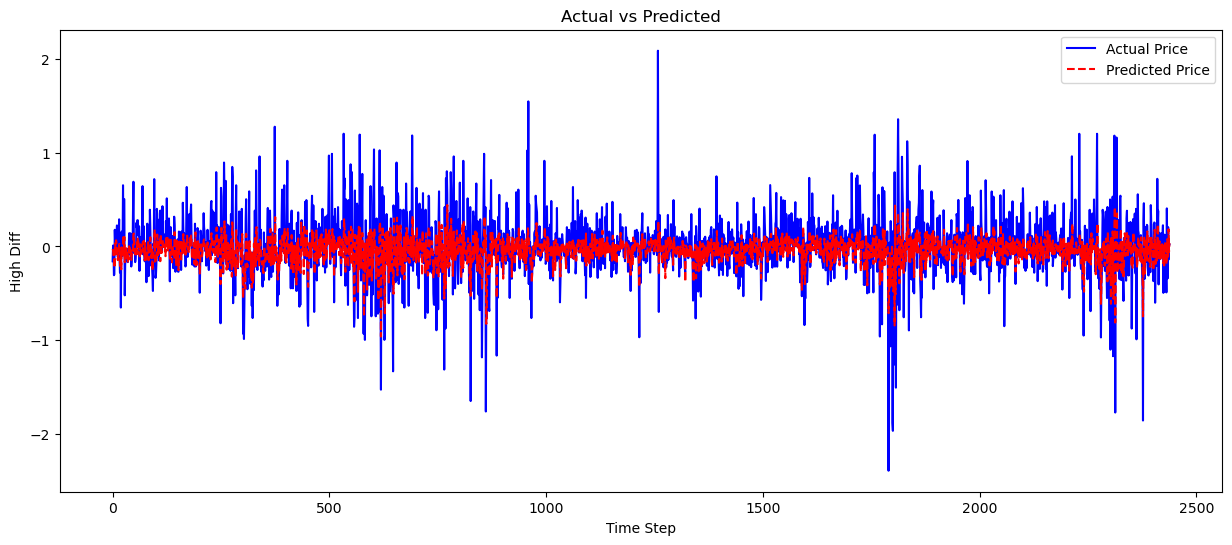

In [50]:
data_to_predict = train_data
actual_prediction = train_target

attention.evaluate(data_to_predict, actual_prediction)

# TESTing: DENORMALIZE TARGET AND PREDICTIONS ##
price_predicted_array = scaler_target.inverse_transform(attention.predict(data_to_predict).squeeze().reshape(-1, 1))
price_actual_array = scaler_target.inverse_transform(actual_prediction).flatten()


## Evaluation
evaluate_price_predictions(price_predicted_array.flatten(), price_actual_array.flatten())

# ## PLOTting #
plot_results(price_actual_array, price_predicted_array, target_column_name)

9/9 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.24
Mean Absolute Percentage Error (MAPE): 1996.43%
R-squared (R²): -3.97


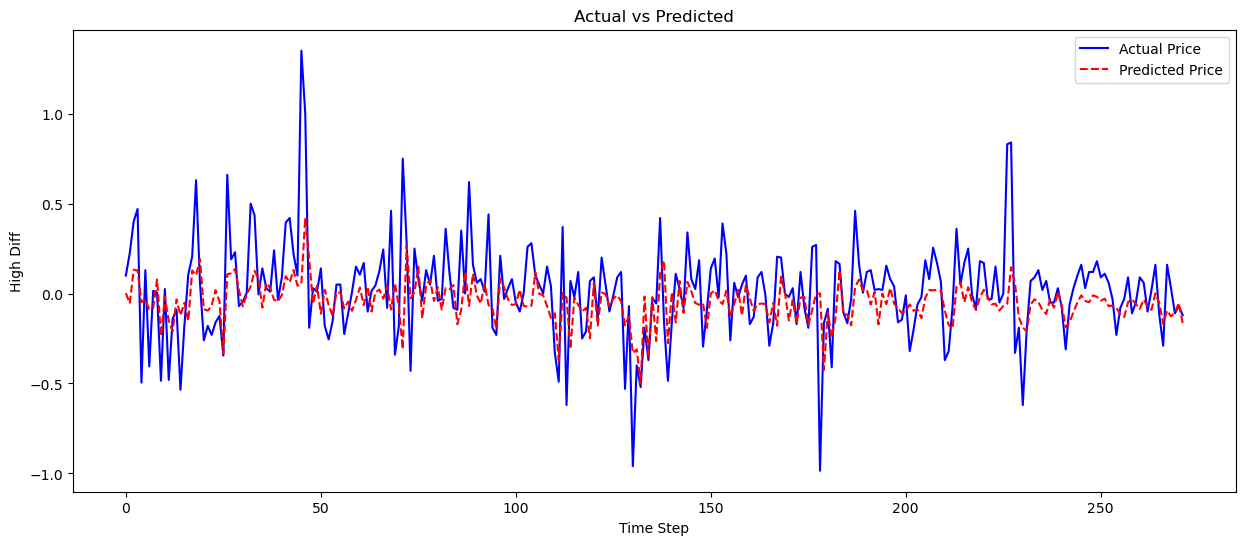

In [51]:
data_to_predict = test_data
actual_prediction = test_target

attention.evaluate(data_to_predict, actual_prediction)

# TESTing: DENORMALIZE TARGET AND PREDICTIONS ##
price_predicted_array = scaler_target.inverse_transform(attention.predict(data_to_predict).squeeze().reshape(-1, 1))
price_actual_array = scaler_target.inverse_transform(actual_prediction).flatten()

## Evaluation
evaluate_price_predictions(price_predicted_array.flatten(), price_actual_array.flatten())

## PLOTting #
plot_results(price_actual_array, price_predicted_array, target_column_name)

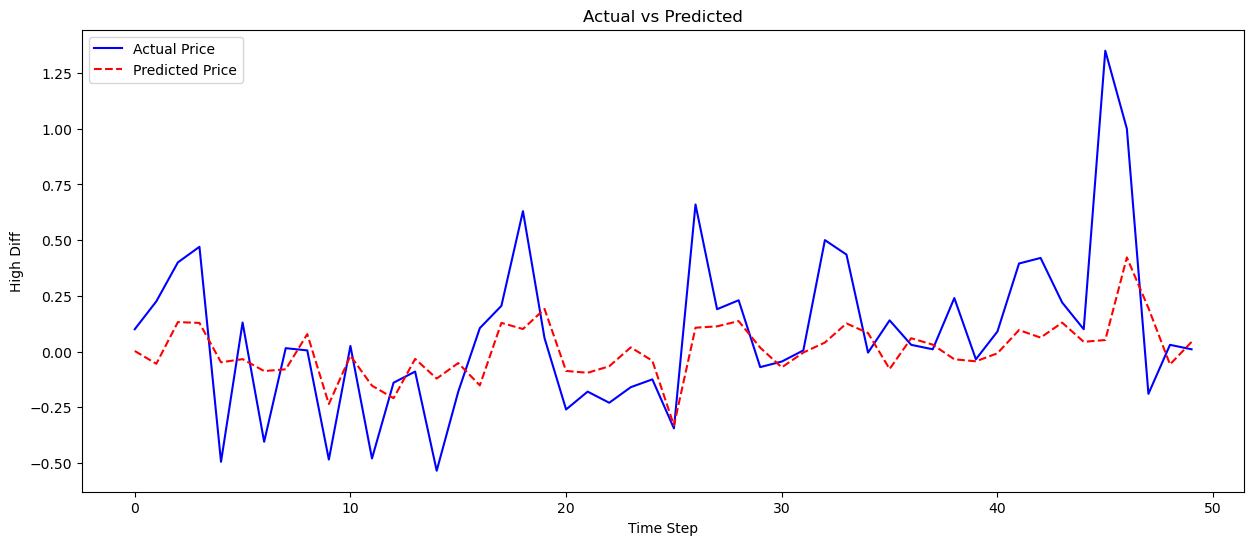

In [52]:
plot_results(price_actual_array[:50], price_predicted_array[:50], target_column_name)


Mean Absolute Error (MAE): 0.12

In [ ]:
# model.save(path)